In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import os
from imblearn.over_sampling import SMOTE
from sample import create_sampler
from tree_extractor import path_extractor
from model_extractor import Extractor
from lightgbm import LGBMClassifier
import pickle

random_state = 114

class ExpModel:
    def __init__(self, dataset, model, random_state):
        self.dataset = dataset
        self.model = model
        self.n_splits = 4
        self._accuracy = []
        self._precision = []
        self._recall = []
        self._f1_score = []

    def init(self):
        if self.model == 'RF':
            if self.dataset == 'german_credit':
                self.target = 'Creditability'
                parameters = {
                    'random_state': random_state,
                    #'criterion': 'entropy',
                    'max_depth': 12,
                    #'max_features': 'auto',
                    #'oob_score': True,
                    'n_estimators': 150,
                    'max_leaf_nodes': 100,
                    'min_samples_split': 6,
                    'min_samples_leaf': 3,
                    'bootstrap': True,
                }

                data_table = pd.read_csv('data/german.csv')          
                purposes = [
                    "car (new)",
                    "car (used)",
                    "furniture/equipment",
                    "radio/television",
                    "domestic appliances",
                    "repairs",
                    "education",
                    "vacation",
                    "retraining",
                    "business",
                    "others"
                ]
                concurrent_credits = ['', 'bank', 'stores', 'none']
                housings = ['', 'rent', 'own', 'for free']
                for i in np.unique(data_table['Purpose'].values):
                    data_table['Purpose - '+ purposes[i]] = data_table['Purpose'].values == i
                for i in np.unique(data_table['Type of apartment'].values):
                    data_table['Housing - '+ housings[i]] = data_table['Type of apartment'].values == i
                #for i in np.unique(data_table['Other installment plans'].values):
                #    data_table['installment - '+ concurrent_credits[i]] = data_table['Other installment plans'].values == i
                data_table['no savings account'] = data_table['Value Savings/Stocks'] == 5
                data_table['Value Savings/Stocks'] = np.array([v if v < 5 else 0 for v in data_table['Value Savings/Stocks'].values])
                data_table['no checking account'] = data_table['Account Balance'].values == 4
                data_table['Account Balance'] = np.array([v if v < 4 else 0 for v in data_table['Account Balance'].values])
                data_table = data_table.drop('Purpose', axis = 1)
                data_table = data_table.drop('Type of apartment', axis = 1)
                #data_table = data_table.drop('Other installment plans', axis = 1)
                X = data_table.drop(self.target, axis=1).values
                y = data_table[self.target].values
            self.data_table = data_table
            self.X = X
            self.y = y
            self.parameters = parameters
            
            kf = KFold(n_splits = self.n_splits, random_state=random_state, shuffle=True)
            self.splits = []
            for train_index, test_index in kf.split(X):
                self.splits.append((train_index, test_index))
            self.fold = 0

    def has_next_fold(self):
        return self.fold < len(self.splits)
    
    def next_fold(self):
        self.fold += 1

    def train(self):
        sm = SMOTE(random_state=random_state)
        data_table = self.data_table
        X = self.X
        y = self.y
        parameters = self.parameters
        train_index, test_index = self.splits[self.fold]
        X_train = self.X[train_index]
        y_train = self.y[train_index]
        X_test = self.X[test_index]
        y_test = self.y[test_index]
        X_train, y_train = sm.fit_resample(X_train, y_train)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.data_table = data_table

        clf = LGBMClassifier(
            learning_rate=0.1,
            n_estimators=100,
            num_leaves=50,
            reg_alpha=3,
            max_depth=8,
            random_state=random_state,
        )
        #clf = RandomForestClassifier(**parameters)
        print(X_train[1])
        print(X_train.shape, y_train.shape)
        clf.fit(X_train, y_train)
        self.clf = clf
        self.y_pred = clf.predict(X_test)
        self.features = data_table.drop(self.target, axis=1).columns.to_list()

    def evaluate(self):
        _accuracy = accuracy_score(self.y_test, self.y_pred)
        _precision = precision_score(self.y_test, self.y_pred)
        _recall = recall_score(self.y_test, self.y_pred)
        _f1_score = f1_score(self.y_test, self.y_pred)
        #print('Accuracy Score is', _accuracy)
        #print('Precision is', _precision)
        #print('Recall is', _recall)
        #print('F1 Score is', _f1_score)
        self._accuracy.append(_accuracy)
        self._precision.append(_precision)
        self._recall.append(_recall)
        self._f1_score.append(_f1_score)
    
    def summary(self):
        return float(np.mean(self._accuracy)), float(np.mean(self._precision)), float(np.mean(self._recall)), float(np.mean(self._f1_score))

    def oversampling(self, rate = 2):
        is_continuous = []
        is_categorical = []
        is_integer = []

        for feature in self.data_table.columns:
            if feature == self.target:
                continue
            if self.data_table[feature].dtype == 'O':
                is_continuous.append(False)
                is_categorical.append(True)
            else:
                is_continuous.append(True)
                is_categorical.append(False)
            is_integer.append(False)
        sampler = create_sampler(self.X_train, is_continuous, is_categorical, is_integer)
        return sampler(len(self.X_train) * rate)

    def generate_paths(self):
        if self.model == 'RF':
            paths = path_extractor(self.clf, 'random forest', (self.X_train, self.y_train))
        else:
            paths = path_extractor(self.clf, 'lightgbm')
        print('num of paths', len(paths))
        return paths


num_of_rules = [50, 100, 200, 400, 800, 1600]
tau_of_rules = [1, 1, 1.5, 1.75, 2.0, 2.5]
exp_models = ['RF']
exp_datasets = ['german_credit']

best_accuracy = 0
for rs in range(200):
    for dataset in exp_datasets:
        for model in exp_models:
            exp = ExpModel(dataset, model, rs)
            exp.init()
            while exp.has_next_fold():
                exp.train()
                exp.evaluate()
                exp.next_fold()
            summary = exp.summary()
            if summary[0] > best_accuracy:
                best_accuracy = summary[0]
                print(rs, best_accuracy)
            #print(summary)



[1.000e+00 9.000e+00 4.000e+00 2.799e+03 1.000e+00 3.000e+00 2.000e+00
 3.000e+00 1.000e+00 2.000e+00 1.000e+00 3.600e+01 3.000e+00 2.000e+00
 3.000e+00 2.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
(1036, 33) (1036,)
[  2.  12.   2. 841.   2.   4.   2.   2.   1.   4.   1.  23.   3.   1.
   2.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.
   1.   0.   0.   0.   0.]
(1046, 33) (1046,)
[1.000e+00 9.000e+00 4.000e+00 2.799e+03 1.000e+00 3.000e+00 2.000e+00
 3.000e+00 1.000e+00 2.000e+00 1.000e+00 3.600e+01 3.000e+00 2.000e+00
 3.000e+00 2.000e+00 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
(1064, 33) (1064,)
[  2.  12.   2. 841.   2.   4.   2.   2.   1.   4.   1.  23.   3.   1.
   2.   1.   1.   1.   0.   0. 

KeyboardInterrupt: 

In [51]:
import csv
import matplotlib.pyplot as plt
import numpy as np


reader = csv.reader(open('summary2.csv', 'r'))
rows = []
for row in reader:
    rows.append(row)
rows = rows[1:]

def summarize(name):
    data = [row for row in rows if row[0] == name and row[1] == '0']
    data = [(float(row[3]), float(row[7]), float(row[8])) for row in data]
    data = sorted(data, key=lambda x:x[0])
    nd = []
    for i in range(0, len(data), 4):
        nd.append((data[i][0], np.mean([v[1] for v in data[i: i + 4]]), np.mean([v[2] for v in data[i: i + 4]])))
    x = [v[0] for v in nd]
    y1 = [v[1] for v in nd]
    y2 = [v[2] for v in nd]
    for i in range(1, len(y1)):
        y1[i] = max(y1[i - 1], y1[i]) + 0.001
        y2[i] = max(y2[i - 1], y2[i]) + 0.001
    plt.plot(x, y1, label='Accuracy')
    plt.plot(x, y2, label='Fidelity')
    plt.xlabel('num of rules')
    plt.ylabel('rate')
    plt.title(name + ' dataset')
    plt.xscale('log')
    print(x)
    plt.xticks(x, [str(v) for v in x])
    plt.legend()
    plt.show()


[50.0, 100.0, 200.0, 400.0, 1600.0]


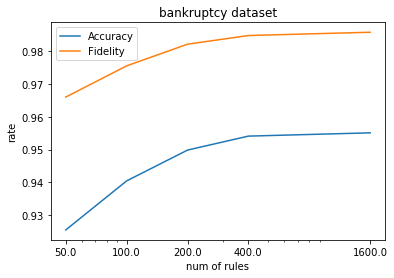

In [54]:
summarize('bankruptcy')

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np


reader = csv.reader(open('summary_sbrl.csv', 'r'))
rows = []
for row in reader:
    rows.append(row)
rows = rows[1:]


In [19]:
name = 'wine'
data = [row for row in rows if row[0] == name]
data = [(float(row[9]), float(row[7]), float(row[8])) for row in data if row[1] == '4']
data = sorted(data, key=lambda x:x[0])

In [20]:
data1 = [d for d in data if d[0] < 200]
print(np.mean([d[1] for d in data1]))
print(np.mean([d[2] for d in data1]))
print(np.mean([d[0] for d in data1]))

0.43000751879699245
0.44702005012531326
83.6


In [21]:
data1 = [d for d in data if d[0] > 200]
print(np.max([d[1] for d in data1]))
print(np.max([d[2] for d in data1]))
print(np.max([d[0] for d in data1]))

ValueError: zero-size array to reduction operation maximum which has no identity